# Text-to-Speech GlowTTS Multispeakers

GlowTTS, Text to Melspectrogram.

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/tts-glowtts-multispeaker](https://github.com/huseinzol05/malaya-speech/tree/master/example/tts-glowtts-multispeaker).
    
</div>

<div class="alert alert-warning">

This module is not language independent, so it not save to use on different languages. Pretrained models trained on hyperlocal languages.
    
</div>

<div class="alert alert-warning">

This is an application of malaya-speech Pipeline, read more about malaya-speech Pipeline at [malaya-speech/example/pipeline](https://github.com/huseinzol05/malaya-speech/tree/master/example/pipeline).
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import matplotlib.pyplot as plt
import IPython.display as ipd

### GlowTTS Multispeakers description

1. Malaya-speech GlowTTS will generate melspectrogram with feature size 80.
2. Use Malaya-speech vocoder to convert melspectrogram to waveform.
3. Able to accept any speaker in 16k wav format for input speaker and do voice conversion for target speaker.

### List available GlowTTS

In [2]:
malaya_speech.tts.available_glowtts()

INFO:root:`haqkiem` and `female-singlish` combined loss from training set


,Size (MB),Quantized Size (MB),Combined loss
male,119.0,27.6,-1.429
female,119.0,27.6,-1.464
haqkiem,119.0,27.6,-1.649
female-singlish,119.0,27.6,-1.728
multispeaker,404.0,79.9,-1.882


`haqkiem` voice contributed by [Haqkiem Hamdan](https://www.linkedin.com/in/haqkiem-daim/), recorded using high-end microphone in an audio studio.

`female-singlish` voice contributed by [SG National Speech Corpus](https://www.imda.gov.sg/programme-listing/digital-services-lab/national-speech-corpus), recorded using high-end microphone in an audio studio.

### Load GlowTTS model

Fastspeech2 use text normalizer from Malaya, https://malaya.readthedocs.io/en/latest/load-normalizer.html#Load-normalizer,

Make sure you install Malaya version > 4.0 and Malaya-Boilerplate >= 0.0.12 to make it works,

```bash
pip install malaya -U
```

```python
def glowtts(model: str = 'male',
            quantized: bool = False,
            pad_to: int = 2,
            true_case_model=None,
            **kwargs):
    """
    Load GlowTTS TTS model.

    Parameters
    ----------
    model : str, optional (default='male')
        Model architecture supported. Allowed values:

        * ``'female'`` - GlowTTS trained on female voice.
        * ``'male'`` - GlowTTS trained on male voice.
        * ``'haqkiem'`` - GlowTTS trained on Haqkiem voice, https://www.linkedin.com/in/haqkiem-daim/
        * ``'female-singlish'`` - GlowTTS trained on female Singlish voice, https://www.imda.gov.sg/programme-listing/digital-services-lab/national-speech-corpus
        * ``'multispeaker'`` - Multispeaker GlowTTS trained on male, female, husein and haqkiem voices, also able to do voice conversion.

    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model.
        Quantized model not necessary faster, totally depends on the machine.
    pad_to : int, optional (default=2)
        size of pad character with 0. Increase can stable up prediction on short sentence, we trained on 2.
    true_case_model: str, optional (default=None)
        load any true case model, eg, malaya true case model from https://malaya.readthedocs.io/en/latest/load-true-case.html
        the interface must accept a string, return a string, eg, string = true_case_model(string)

    Returns
    -------
    result : malaya_speech.model.tf.GlowTTS class
    """
```

In [3]:
multispeaker = malaya_speech.tts.glowtts(model = 'multispeaker')

INFO:root:running speaker-vector/vggvox-v2 using device /device:CPU:0
INFO:root:running tts/glowtts-multispeaker using device /device:CPU:0


In [4]:
# https://www.sinarharian.com.my/article/115216/BERITA/Politik/Syed-Saddiq-pertahan-Dr-Mahathir
string1 = 'Syed Saddiq berkata, mereka seharusnya mengingati bahawa semasa menjadi Perdana Menteri Pakatan Harapan (PH), Dr Mahathir telah melantik ramai di kalangan menteri dan timbalan menteri daripada golongan muda.'

### Predict

```python
def predict(
    self,
    string,
    audio,
    temperature: float = 0.3333,
    length_ratio: float = 1.0,
    **kwargs,
):
    """
    Change string to Mel.

    Parameters
    ----------
    string: str
    audio: np.array
        np.array or malaya_speech.model.frame.Frame, must in 16k format.
        We only trained on `female`, `male`, `husein` and `haqkiem` speakers.
    temperature: float, optional (default=0.3333)
        Decoder model trying to decode with encoder(text) + random.normal() * temperature.
    length_ratio: float, optional (default=1.0)
        Increase this variable will increase time voice generated.

    Returns
    -------
    result: Dict[string, ids, alignment, universal-output]
    """
```

It only able to predict 1 text for single feed-forward.

In [5]:
female, _ = malaya_speech.load('speech/example-speaker/female.wav')
haqkiem, _ = malaya_speech.load('speech/example-speaker/haqkiem.wav')
khalil, _ = malaya_speech.load('speech/example-speaker/khalil-nooh.wav')
muhyiddin, _ = malaya_speech.load('speech/example-speaker/muhyiddin-yassin.wav')

In [6]:
r = multispeaker.predict(string1, female)

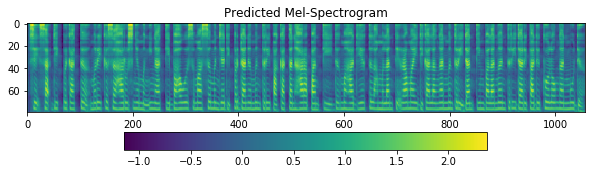

In [8]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title('Predicted Mel-Spectrogram')
im = ax1.imshow(np.rot90(r['universal-output']), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

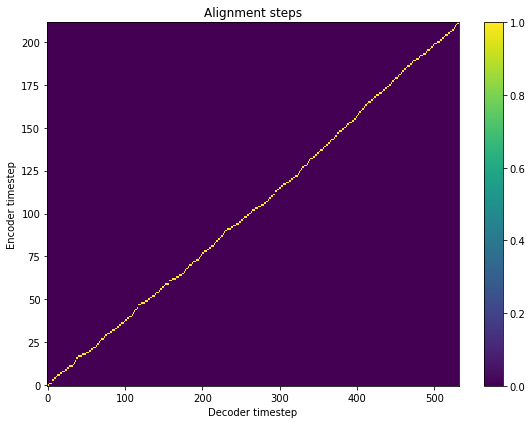

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set_title('Alignment steps')
im = ax.imshow(
    r['alignment'],
    aspect='auto',
    origin='lower',
    interpolation='none')
fig.colorbar(im, ax=ax)
xlabel = 'Decoder timestep'
plt.xlabel(xlabel)
plt.ylabel('Encoder timestep')
plt.tight_layout()
plt.show()

### Load Vocoder model

There are 2 ways to synthesize melspectrogram output from TTS models,

1. If you are going to use individual speaker vocoder, make sure the speakers are the same If use female tacotron2, need to use female MelGAN also. Use `postnet-output` from TTS model. Read more at https://malaya-speech.readthedocs.io/en/latest/load-vocoder.html
2. If you are going to use universal MelGAN, use `universal-output` from TTS model. Read more at https://malaya-speech.readthedocs.io/en/latest/load-universal-melgan.html

We prefer individual speaker vocoder, size only 17MB and faster than universal vocoder.

In [10]:
universal_melgan = malaya_speech.vocoder.melgan(model = 'universal-1024')

INFO:root:running vocoder-melgan/universal-1024 using device /device:CPU:0


In [11]:
y_ = universal_melgan(r['universal-output'])
ipd.Audio(y_, rate = 22050)

### Voice Conversion

```python
def voice_conversion(self, string, original_audio, target_audio,
                     temperature: float = 0.3333,
                     length_ratio: float = 1.0,
                     **kwargs,):
    """
    Change string to Mel.

    Parameters
    ----------
    string: str
    original_audio: np.array
        original speaker to encode speaking style, must in 16k format.
    target_audio: np.array
        target speaker to follow speaking style from `original_audio`, must in 16k format.
    temperature: float, optional (default=0.3333)
        Decoder model trying to decode with encoder(text) + random.normal() * temperature.
    length_ratio: float, optional (default=1.0)
        Increase this variable will increase time voice generated.

    Returns
    -------
    result: Dict[string, ids, alignment, universal-output]
    """
```

In [15]:
r = multispeaker.voice_conversion(string1, female, haqkiem, length_ratio = 1.2)
y_ = universal_melgan(r['universal-output'])
ipd.Audio(y_, rate = 22050)

In [ ]:
r = multispeaker.voice_conversion(string1, haqkiem, khalil, length_ratio = 1.2)
y_ = universal_melgan(r['universal-output'])
ipd.Audio(y_, rate = 22050)